# Домашнее задание

В этом домашнем задании вы обучите полносвязную нейронную сеть для решения задачи классификации на датасете CIFAR-10.

Это домашнее задание оформлено в не совсем традиционном формате. Не хочется заставлять вас копировать код. Вы будете менять уже существующую архитектуру, а затем отвечать на вопросы.

## Задание 1

Запустите данный изначально код и замерьте качество (accuracy) на тестовых данных. Ответ округлите до целого числа.

## Задание 2

Добавьте еще один полносвязный слой (перед выходным) из 100 нейронов + функцию активации ReLU и запустите обучение. Выберите в ответе accuracy, наиболее близкую к полученной на тесте.

## Задание 3

Теперь обучите полносвязную сеть с несколькими линейными слоями с числом нейронов: 1024, 512, 256, 128, 64 соответственно + функцией ReLU на выходе из каждого внутреннего слоя. В ответе - accuracy, округленная до целого числа.

## Задание 4

К архитектуре из предыдущего задания добавьте Dropout(0.2) перед слоями из 1024 и 256 нейронов. Увеличилась ли accuracy по сравнению с предыдущим заданием?

## Задание 5

Уберите Dropout, но добавьте BatchNorm перед входом в те же линейные слои. Увеличилась ли accuracy по сравнению с заданием 3?

## Задание 6

Теперь пробуйте что угодно:
* разное число линейных слоев
* разные функции активации (вместо ReLU)
* комбинации Dropout / BatchNorm
* можете попробовать умные инициализации весов и другие трюки из урока

Цель - добиться наибольшей accuracy на тесте.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

In [23]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters
input_size = 3072
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

In [24]:
# MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='../../data',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data',
                                          train=False,
                                          transform=transform)

Files already downloaded and verified


In [25]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [57]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(128, 64)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(64, num_classes)
#        self.apply(self._init_weights)

    def _init_weights(self, module): # метод для различных "умных" инициализаций весов
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.15)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.batchnorm(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.batchnorm2(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.fc6(out)
        return out

model = NeuralNet(input_size, num_classes).to(device)

In [58]:
model

NeuralNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (relu): ReLU()
  (batchnorm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (relu3): ReLU()
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=64, out_features=10, bias=True)
)

In [36]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [59]:
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

loss_log = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.reshape(-1, 32*32*3).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            loss_log.append(loss.data.cpu().numpy())

Epoch [1/10], Step [100/1563], Loss: 2.2873
Epoch [1/10], Step [200/1563], Loss: 2.2994
Epoch [1/10], Step [300/1563], Loss: 2.3497
Epoch [1/10], Step [400/1563], Loss: 2.3217
Epoch [1/10], Step [500/1563], Loss: 2.3470
Epoch [1/10], Step [600/1563], Loss: 2.3789
Epoch [1/10], Step [700/1563], Loss: 2.3224
Epoch [1/10], Step [800/1563], Loss: 2.3116
Epoch [1/10], Step [900/1563], Loss: 2.2899
Epoch [1/10], Step [1000/1563], Loss: 2.3311
Epoch [1/10], Step [1100/1563], Loss: 2.2842
Epoch [1/10], Step [1200/1563], Loss: 2.2735
Epoch [1/10], Step [1300/1563], Loss: 2.3196
Epoch [1/10], Step [1400/1563], Loss: 2.3246
Epoch [1/10], Step [1500/1563], Loss: 2.2959
Epoch [2/10], Step [100/1563], Loss: 2.2875
Epoch [2/10], Step [200/1563], Loss: 2.3121
Epoch [2/10], Step [300/1563], Loss: 2.3334
Epoch [2/10], Step [400/1563], Loss: 2.3085
Epoch [2/10], Step [500/1563], Loss: 2.3372
Epoch [2/10], Step [600/1563], Loss: 2.3241
Epoch [2/10], Step [700/1563], Loss: 2.3251
Epoch [2/10], Step [800/15

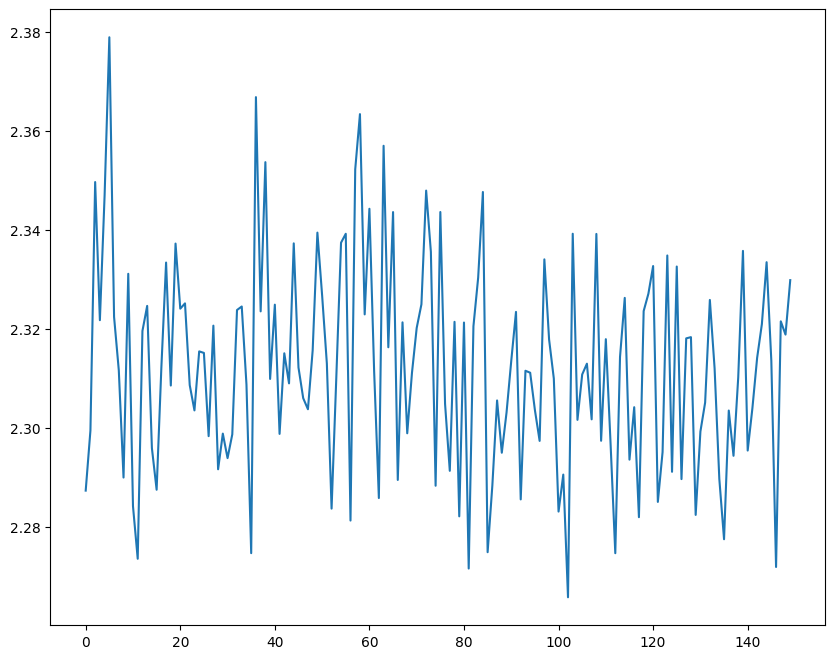

In [60]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(loss_log)

In [63]:
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

# Test the model
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 32*32*3).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Accuracy of the network on the test images: 9.73 %
